In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import r2_score


In [ ]:
column_names = ["Date", "OilPrice"]
brent_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls", sheet_name=1, skiprows=4, engine='xlrd',names=column_names)
print(brent_data.head())

        Date  OilPrice
0 1987-05-22     18.55
1 1987-05-25     18.60
2 1987-05-26     18.63
3 1987-05-27     18.60
4 1987-05-28     18.60


In [ ]:
oil_prices = brent_data['OilPrice']
dates = brent_data['Date']


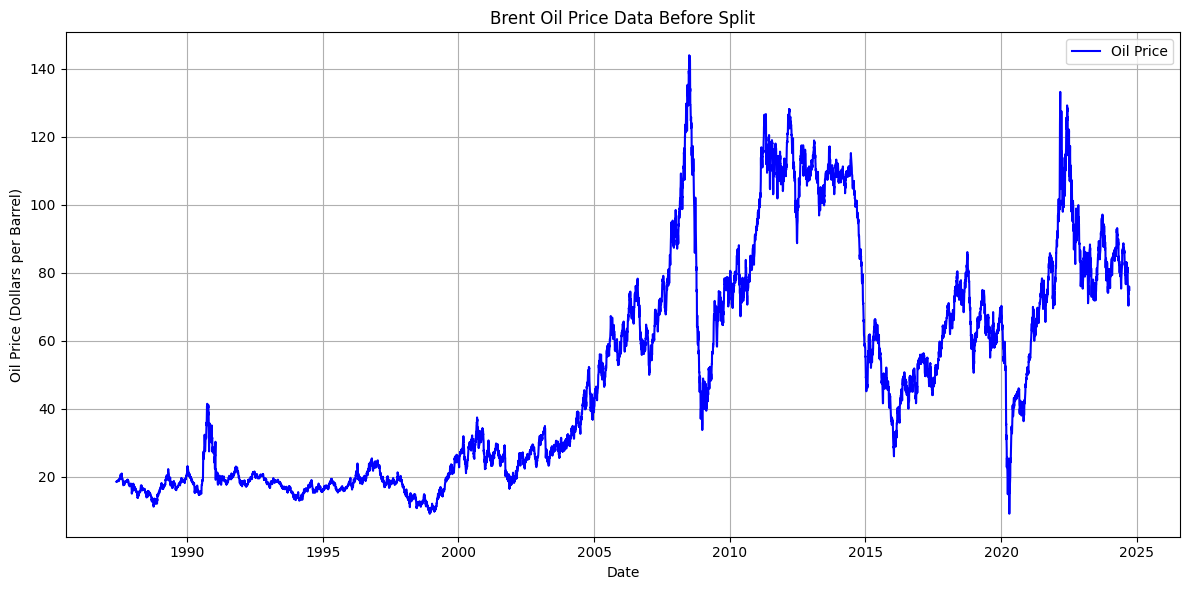

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(brent_data['Date'], brent_data['OilPrice'], label='Oil Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price Data Before Split')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# scaler = MinMaxScaler()
brent_data['normalized_oil_prices'] = brent_data['OilPrice']
brent_data.head()

,Date,OilPrice,normalized_oil_prices
0,1987-05-22,18.55,18.55
1,1987-05-25,18.60,18.60
2,1987-05-26,18.63,18.63
3,1987-05-27,18.60,18.60
4,1987-05-28,18.60,18.60


In [ ]:
split_date = pd.to_datetime("2010-01-01")
cutoff_date = pd.to_datetime("2023-01-01")

nearest_date = brent_data.loc[brent_data['Date'] >= split_date, 'Date'].min()
nearest_cutoff = brent_data.loc[brent_data['Date'] >= cutoff_date, 'Date'].min()

split_index = brent_data[brent_data['Date'] == nearest_date].index[0]
cutoff_index = brent_data[brent_data['Date'] == nearest_cutoff].index[0]

train_values = brent_data['normalized_oil_prices'][split_index:cutoff_index]
train_dates = brent_data['Date'][split_index:cutoff_index]

test_values = brent_data['normalized_oil_prices'][cutoff_index:]
test_real = brent_data['OilPrice'][cutoff_index:]
test_dates = brent_data['Date'][cutoff_index:]

train_values = train_values.reset_index(drop=True)
train_dates = train_dates.reset_index(drop=True)
test_values = test_values.reset_index(drop=True)
test_dates = test_dates.reset_index(drop=True)
test_real = test_real.reset_index(drop=True)

In [ ]:
print(test_real)

0      80.36
1      75.31
2      76.73
3      76.41
4      77.50
       ...  
431    74.55
432    74.52
433    75.93
434    75.96
435    74.95
Name: OilPrice, Length: 436, dtype: float64


In [ ]:
print(train_values)
print(train_dates)
print(test_values)
print(test_dates)

0       79.05
1       79.27
2       80.14
3       80.57
4       80.06
        ...  
3285    79.58
3286    82.45
3287    81.70
3288    80.96
3289    82.82
Name: normalized_oil_prices, Length: 3290, dtype: float64
0      2010-01-04
1      2010-01-05
2      2010-01-06
3      2010-01-07
4      2010-01-08
          ...    
3285   2022-12-22
3286   2022-12-23
3287   2022-12-28
3288   2022-12-29
3289   2022-12-30
Name: Date, Length: 3290, dtype: datetime64[ns]
0      80.36
1      75.31
2      76.73
3      76.41
4      77.50
       ...  
431    74.55
432    74.52
433    75.93
434    75.96
435    74.95
Name: normalized_oil_prices, Length: 436, dtype: float64
0     2023-01-03
1     2023-01-04
2     2023-01-05
3     2023-01-06
4     2023-01-09
         ...    
431   2024-09-17
432   2024-09-18
433   2024-09-19
434   2024-09-20
435   2024-09-23
Name: Date, Length: 436, dtype: datetime64[ns]


In [ ]:
print("Training data shape:", train_values.shape)
print("Testing data shape:", test_values.shape)

Training data shape: (3290,)
Testing data shape: (436,)


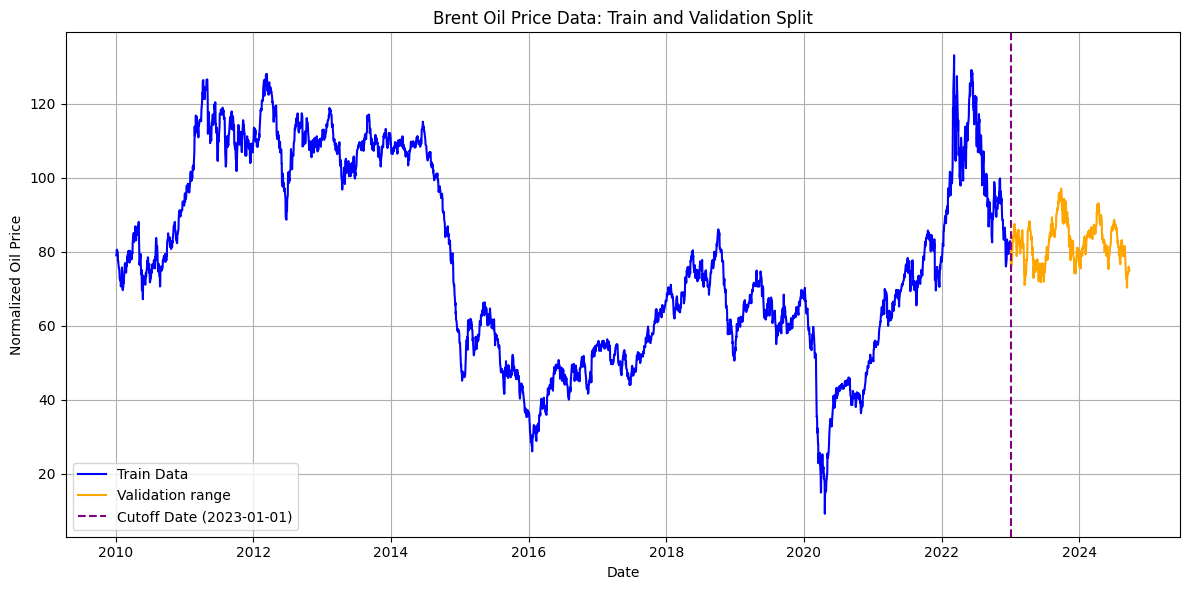

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train_values, label='Train Data', color='blue')
plt.plot(test_dates, test_values, label='Validation range', color='orange')
plt.axvline(x=nearest_cutoff, color='purple', linestyle='--', label='Cutoff Date (2023-01-01)')
plt.xlabel('Date')
plt.ylabel('Normalized Oil Price')
plt.title('Brent Oil Price Data: Train and Validation Split')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length (number of time steps to look back)
sequence_length = 7

In [ ]:
X_train, y_train = create_sequences(train_values, sequence_length)
X_test, y_test = create_sequences(test_values, sequence_length)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3283, 7)
(3283,)
(429, 7)
(429,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3283, 7, 1)
(3283,)
(429, 7, 1)
(429,)


In [ ]:
# from tensorflow.keras.models import load_model

# # Specify the file name of your model (change 'your_model_file.h5' to your actual file name)
# model_file_name = 'stream_best.keras'

# # Load the model
# model = load_model(model_file_name)


In [ ]:
# Step 2: Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Step 3: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Step 4: Fit the model to the training data
model.fit(X_train, y_train, epochs=25, batch_size=32)

# for epoch in range(25):  # 25 epochs
#     for batch_start in range(0, len(X_train), 32):  # Batch size of 32
#         X_batch = X_train[batch_start:batch_start + 32]
#         y_batch = y_train[batch_start:batch_start + 32]
#         model.train_on_batch(X_batch, y_batch)


# Step 5: Evaluate the model on the test data
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6701.3154
Epoch 2/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5105.3066
Epoch 3/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4357.5127
Epoch 4/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3745.1235
Epoch 5/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3243.8594
Epoch 6/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2835.1487
Epoch 7/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2440.4851
Epoch 8/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2111.4143
Epoch 9/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1851.1335
Epoch 10/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1563.8289
Epoch 11/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1455.4272
Epoch 12/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1195.5161
Epoch 13/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1132.1776
Epoch 14/25
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 954.9337
Epoch 15/25
103/

In [ ]:
print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 217.14378356933594
Test Loss: 10.398029327392578


In [ ]:
data_queue = train_values[-7:].tolist()
print(data_queue)

[79.45, 80.25, 79.58, 82.45, 81.7, 80.96, 82.82]


In [ ]:
print(test_values)

0      80.36
1      75.31
2      76.73
3      76.41
4      77.50
       ...  
431    74.55
432    74.52
433    75.93
434    75.96
435    74.95
Name: normalized_oil_prices, Length: 436, dtype: float64


In [ ]:
print(data_queue)

[79.45, 80.25, 79.58, 82.45, 81.7, 80.96, 82.82]


In [ ]:
import tensorflow as tf

In [ ]:
for i in data_queue:
  print(type(i))


<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [ ]:
print(len(test_values))


229


# Day wise prediction

Here when predicting d+1 day. d days original values are given

In [ ]:
count = 1
predicted_prices = []
data_queue = test_values[13:20].tolist()
original_prices = test_real[20:50].tolist()
for day in range(20,50):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = next_day_prediction
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(original_value)
    data_queue.pop(0)
    X_new = data_queue[-sequence_length:]
    y_new = np.array([original_value])  # Shape should match the output shape of your model (26,)
    X_new = np.array(X_new).reshape(1, sequence_length, 1)
    if count % 7 == 0 :
      model.fit(X_new, y_new, epochs=1, batch_size=1)
      print('train')
    print(count)
    count += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
83.76245
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
83.196365
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
81.98288
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
80.57474
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
78.84437
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
79.1542
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
80.70778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.3330
train
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
83.00379
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
83.219986
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
83.96748
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
84.41684
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
84.46475
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
84.34164
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
84.19505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.3063
train
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
83.427475
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
83.224045
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
82.88457
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

In [ ]:
d = {'Dates': test_dates[20:50], 'Original': original_prices, 'Predicted': predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (df_results['Difference'] / df_results['Original']) * 100

df_results.head(30)

,Dates,Original,Predicted,Difference,Difference %
20,2023-01-31,83.42,83.762451,0.342451,0.410514
21,2023-02-01,81.61,83.196365,1.586365,1.943837
22,2023-02-02,80.57,81.982880,1.412880,1.753605
23,2023-02-03,78.85,80.574738,1.724738,2.187365
24,2023-02-06,80.48,78.844368,1.635632,2.032346
25,2023-02-07,82.92,79.154198,3.765802,4.541489
26,2023-02-08,84.17,80.707779,3.462221,4.113367
27,2023-02-09,83.46,83.003792,0.456208,0.546619
28,2023-02-10,85.46,83.219986,2.240014,2.621126
29,2023-02-13,85.98,83.967484,2.012516,2.340680


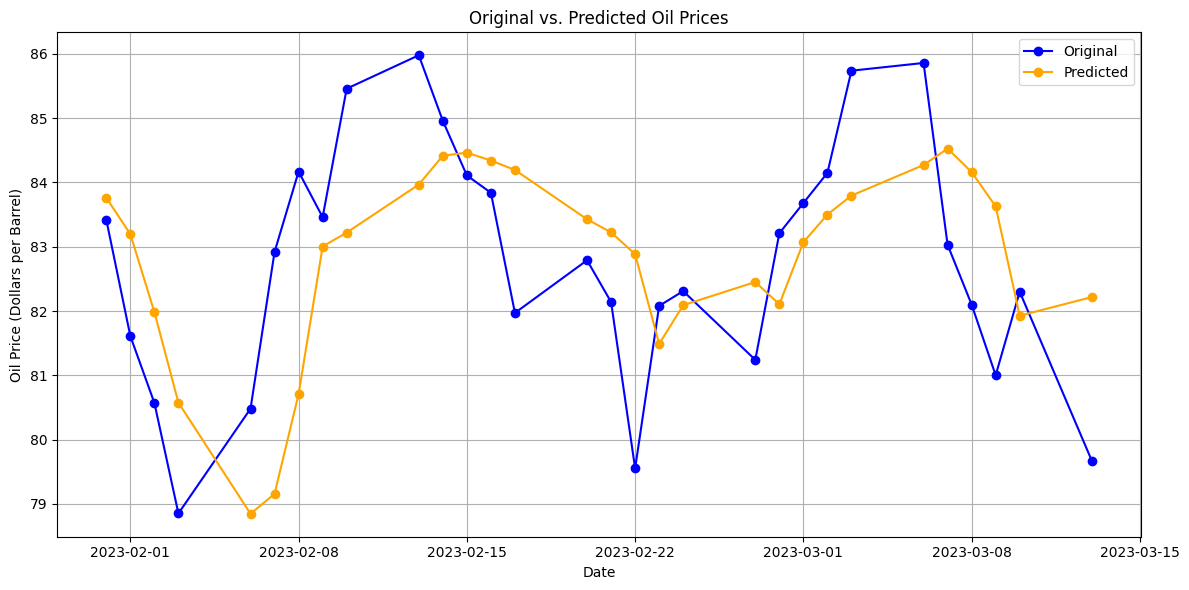

In [ ]:
df_results['Dates'] = pd.to_datetime(df_results['Dates'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot original oil prices
plt.plot(df_results['Dates'], df_results['Original'], label='Original', color='blue', marker='o')

# Plot predicted oil prices
plt.plot(df_results['Dates'], df_results['Predicted'], label='Predicted', color='orange', marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Original vs. Predicted Oil Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 1.77


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  1.792656026774296


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  1.4781834004720054


In [ ]:
def mean_directional_accuracy(y_true, y_pred):
    directions = np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))
    mda = np.mean(directions)
    return mda * 100

mda = mean_directional_accuracy(df_results['Original'], df_results['Predicted'])
print(f"Mean Directional Accuracy (MDA): {mda:.2f}%")


Mean Directional Accuracy (MDA): 62.07%


In [ ]:
r2 = r2_score(df_results['Original'], df_results['Predicted'])
print(f"R-squared (R2) Score: {r2:.2f}")


R-squared (R2) Score: 0.10


Next Range

In [ ]:
predicted_prices = []
count = 0
data_queue = test_values[63:70].tolist()
original_prices = test_real[70:100].tolist()
for day in range(70,100):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = next_day_prediction
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(original_value)
    data_queue.pop(0)
    # print(day)
    if count % 7 == 0 :
      model.fit(X_new, y_new, epochs=1, batch_size=1)
      print('train')
    print(count)
    count += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
84.73591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.8914
train
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
83.834724
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
83.91589
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
83.51175
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
83.27873
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
83.14132
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
82.31109
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
82.08617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1370
train
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
81.52392
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
80.56486
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
78.82794
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79.240906
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79.97056
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
77.383316
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
74.88204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2821
train
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
74.228745
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
d = {'Dates': test_dates[70:100], 'Original': original_prices, 'Predicted': predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (df_results['Difference'] / df_results['Original']) * 100

df_results.head(30)

,Dates,Original,Predicted,Difference,Difference %
70,2023-04-13,86.51,84.735909,1.774091,2.050736
71,2023-04-14,87.31,83.834724,3.475276,3.980387
72,2023-04-17,85.63,83.915894,1.714106,2.001759
73,2023-04-18,85.48,83.511749,1.968251,2.302586
74,2023-04-19,85.34,83.278732,2.061268,2.415359
75,2023-04-20,83.29,83.141319,0.148681,0.178510
76,2023-04-21,83.36,82.311089,1.048911,1.258291
77,2023-04-24,84.23,82.086166,2.143834,2.545214
78,2023-04-25,82.13,81.523918,0.606082,0.737954
79,2023-04-26,79.19,80.564857,1.374857,1.736150


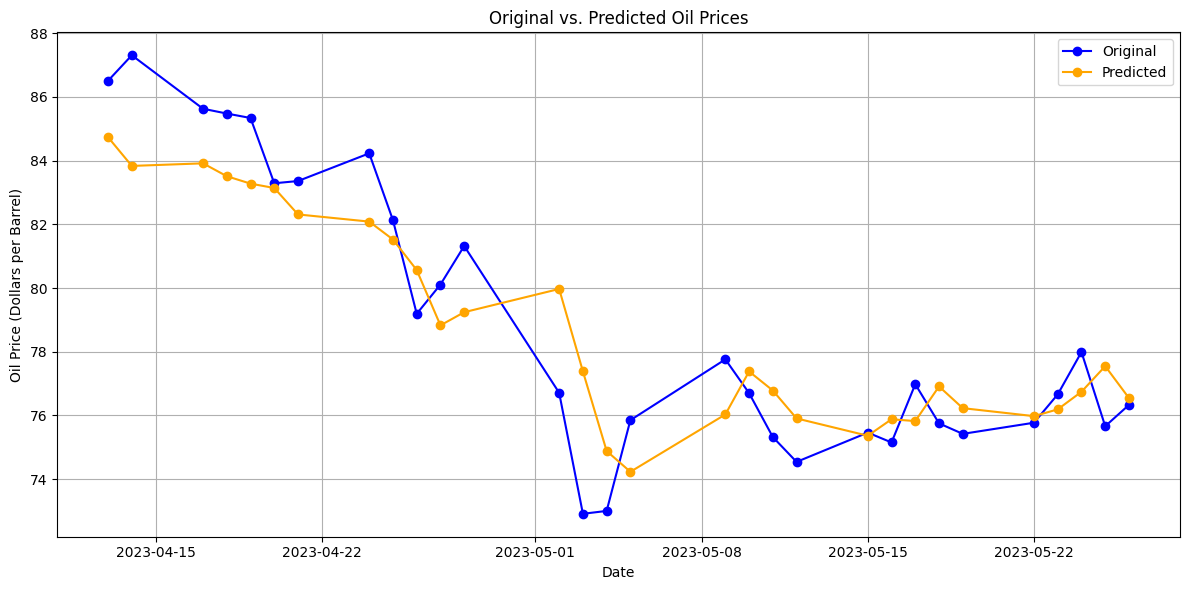

In [ ]:
df_results['Dates'] = pd.to_datetime(df_results['Dates'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot original oil prices
plt.plot(df_results['Dates'], df_results['Original'], label='Original', color='blue', marker='o')

# Plot predicted oil prices
plt.plot(df_results['Dates'], df_results['Predicted'], label='Predicted', color='orange', marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Original vs. Predicted Oil Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 1.77


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  1.8605611203992405


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  1.470987477620443


In [ ]:
mda = mean_directional_accuracy(df_results['Original'], df_results['Predicted'])
print(f"Mean Directional Accuracy (MDA): {mda:.2f}%")


Mean Directional Accuracy (MDA): 44.83%


In [ ]:
r2 = r2_score(df_results['Original'], df_results['Predicted'])
print(f"R-squared (R2) Score: {r2:.2f}")


R-squared (R2) Score: 0.83


**Next Range**

In [ ]:
count = 1
predicted_prices = []
data_queue = test_values[183:190].tolist()
original_prices = test_real[190:220].tolist()
for day in range(190,220):
    input_data = data_queue
    input_data_reshaped = np.array(input_data).reshape(1, sequence_length, 1).astype(np.float32)
    next_day_prediction = model.predict(input_data_reshaped)
    next_day_prediction_original = next_day_prediction
    print(next_day_prediction_original[0][0])
    predicted_prices.append(next_day_prediction_original[0][0])
    original_value = test_values[day]
    data_queue.append(original_value)
    data_queue.pop(0)
    X_new = data_queue[-sequence_length:]
    y_new = np.array([original_value])  # Shape should match the output shape of your model (26,)
    X_new = np.array(X_new).reshape(1, sequence_length, 1)
    if count % 7 == 0 :
      model.fit(X_new, y_new, epochs=1, batch_size=1)
      print('train')
    print(count)
    count += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
84.12768
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
83.2473
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
82.574585
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
82.36865
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
83.31344
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
83.30777
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
82.337425
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 34.4724
train
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
83.216034
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
84.21597
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
83.98974
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
84.174706
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
84.15121
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
84.29732
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
84.40667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 58.9018
train
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
84.79874
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
84.31673
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
84.42064
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/ste

In [ ]:
d = {'Dates': test_dates[190:220], 'Original': original_prices, 'Predicted': predicted_prices}
df_results = pd.DataFrame(d)
df_results['Difference'] = abs(df_results['Original'] - df_results['Predicted'])
df_results['Difference %'] = (df_results['Difference'] / df_results['Original']) * 100

df_results.head(30)

,Dates,Original,Predicted,Difference,Difference %
190,2023-10-04,89.83,84.127678,5.702322,6.347904
191,2023-10-05,88.28,83.247299,5.032701,5.700839
192,2023-10-06,87.86,82.574585,5.285415,6.015724
193,2023-10-09,91.37,82.368652,9.001348,9.851535
194,2023-10-10,90.70,83.313438,7.386562,8.143949
195,2023-10-11,87.58,83.307770,4.272230,4.878089
196,2023-10-12,88.40,82.337425,6.062575,6.858116
197,2023-10-13,94.33,83.216034,11.113966,11.782006
198,2023-10-16,90.99,84.215973,6.774027,7.444804
199,2023-10-17,92.52,83.989738,8.530262,9.219911


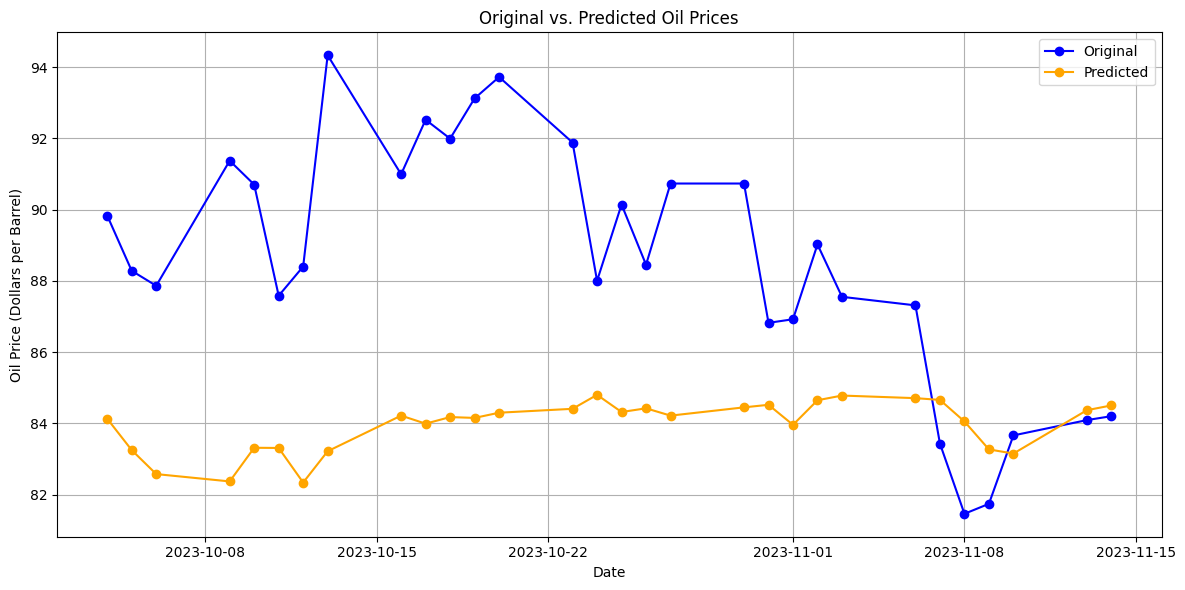

In [ ]:
df_results['Dates'] = pd.to_datetime(df_results['Dates'])

# Plotting
plt.figure(figsize=(12, 6))

# Plot original oil prices
plt.plot(df_results['Dates'], df_results['Original'], label='Original', color='blue', marker='o')

# Plot predicted oil prices
plt.plot(df_results['Dates'], df_results['Predicted'], label='Predicted', color='orange', marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Original vs. Predicted Oil Prices')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(df_results['Original'], df_results['Predicted']))
print(f"Root Mean Squared Error (RMSE) : {rmse:.2f}")

Root Mean Squared Error (RMSE) : 5.79


In [ ]:
error = df_results['Difference %'].mean()
print("Avg error rate : ",error)

Avg error rate :  5.5417803530522765


In [ ]:
error = df_results['Difference'].mean()
print("Avg error  : ",error)

Avg error  :  5.004643137613933


In [ ]:
mda = mean_directional_accuracy(df_results['Original'], df_results['Predicted'])
print(f"Mean Directional Accuracy (MDA): {mda:.2f}%")


Mean Directional Accuracy (MDA): 37.93%


In [ ]:
r2 = r2_score(df_results['Original'], df_results['Predicted'])
print(f"R-squared (R2) Score: {r2:.2f}")


R-squared (R2) Score: -1.89


In [ ]:
model.save_weights('./checkpoints/my_checkpoint')